In [ ]:
%pip install numpy tensorflow plotly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 1. Load data

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Import necessary libraries
import pandas as pd

Mounted at /content/drive


In [ ]:
# Specify the path to the CSV file on Google Drive
one_shot_csv_path = '/content/drive/MyDrive/IoT prj/one_shot.csv'
half_shot_csv_path = '/content/drive/MyDrive/IoT prj/half_shot.csv'
one_shot_csv_path2 = '/content/drive/MyDrive/IoT prj/one_shot_2.csv'
half_shot_csv_path2 = '/content/drive/MyDrive/IoT prj/half_shot_2.csv'


# Load the CSV file into a DataFrame
one_shot = pd.read_csv(one_shot_csv_path)
half_shot = pd.read_csv(half_shot_csv_path)
one_shot_2 = pd.read_csv(one_shot_csv_path2)
half_shot_2 = pd.read_csv(half_shot_csv_path2)

one_shot = pd.concat([one_shot, one_shot_2])
half_shot = pd.concat([half_shot, half_shot_2])

one_shot.dropna(subset=['label'], how='all', inplace=True)
half_shot.dropna(subset=['label'], how='all', inplace=True)

# Print the DataFrame
print(one_shot.head())
print(half_shot.head())

   timestamp  accX  accY  accZ  gyrX  gyrY   gyrZ    label
1   129083.0  -1.0 -0.03 -0.11  1.40  0.37  -0.37  default
2   129091.0  -1.0 -0.03 -0.11  1.40  0.49  -0.37  default
3   129099.0  -1.0 -0.03 -0.10  1.46  0.37  -0.18  default
4   129107.0  -1.0 -0.03 -0.11  1.46  0.61  -0.18  default
5   129115.0  -1.0 -0.03 -0.11  1.22  0.79  -0.12  default
   timestamp  accX  accY  accZ  gyrX  gyrY   gyrZ    label
0      24082  -1.0 -0.04 -0.12  0.79  0.79  -0.12  default
1      24090  -1.0 -0.04 -0.12  0.79  0.79  -0.12  default
2      24098  -1.0 -0.04 -0.12  0.92  0.98  -0.06  default
3      24106  -1.0 -0.04 -0.12  0.92  0.98  -0.06  default
4      24114  -1.0 -0.04 -0.12  0.73  0.73  -0.06  default


In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

# 2. Preprocess data
## 2.1. Remove NaN data

In [ ]:
def impute_mean(dataset, col):
    dataset = dataset.fillna(dataset[col].mean())
    return dataset

In [ ]:
def preprocessing(data):
    label = data['label']
    df = pd.DataFrame(data, columns=['timestamp','accX','accY','accZ','gyrX','gyrY','gyrZ'])
    # replacing 'ovf' for some gyrZ to nan
    df = df.apply(pd.to_numeric, errors='coerce')

    # impute nan with mean value
    df = impute_mean(df, 'gyrZ')
    df['label'] = label
    
    return df

In [ ]:
one_shot = preprocessing(one_shot)
half_shot = preprocessing(half_shot)

## 2.2. Concatenate data

In [ ]:
# data = pd.concat([one_shot, half_shot, default])
data = pd.concat([one_shot, half_shot])

In [ ]:
data['label'].unique()

array(['default', 'oneshot', 'halfshot'], dtype=object)

In [ ]:
print("default:", data[data['label'] == 'default'].shape)
print("half-shot:", data[data['label'] == 'halfshot'].shape)
print("one-shot", data[data['label'] == 'oneshot'].shape)

default: (21532, 8)
half-shot: (18687, 8)
one-shot (15840, 8)


# 3. Feature Extraction
## 3.1 Window sizing

In [ ]:
from statistics import mode
import numpy as np
from sklearn.preprocessing import MinMaxScaler


win_size = 1 * 1000 # window size 
overlap_r = 0.3
bin_size = 256

def feature_extraction(data):
  start_t, end_t = data.loc[:, 'timestamp'].min(), data.loc[:, 'timestamp'].max()

  windows = np.arange(start_t + win_size, end_t, win_size * (1-overlap_r))

  features_t = pd.DataFrame()
  columns = ['timestamp']
  for var in ['accX', 'accY', 'accZ', 'gyrX', 'gyrY', 'gyrZ']:
    columns.append('{}-{}'.format('Min', var))
    columns.append('{}-{}'.format('Max', var))
    columns.append('{}-{}'.format('Mean', var))
    columns.append('{}-{}'.format('Std', var))
  columns.append('label')

  features_t = features_t.reindex(columns=columns)

  for w in windows:
    win_start, win_end = w - win_size, w
    row = [w]
    for var in ['accX', 'accY', 'accZ', 'gyrX', 'gyrY', 'gyrZ', 'label']:
      value = data.query('timestamp >= @win_start and timestamp < @win_end')[var]
      if value.empty:
        continue
      if var == 'label':
        label_v = mode(value)
        row.append(label_v)
      else:
        min_v = np.min(value)
        max_v = np.max(value)
        mean_v = np.mean(value)
        std_v = np.std(value)

        row.append(min_v)
        row.append(max_v)
        row.append(mean_v)
        row.append(std_v)

    if len(row) == 1:
      continue
    features_t.loc[len(features_t)] = row

  # scaled = MinMaxScaler().fit_transform(features_t.drop(['timestamp','label'], axis=1).to_numpy()) # by default, ourput range will be 0~1
  # features_t_scaled = pd.DataFrame(
  #     np.column_stack([features_t.loc[:, 'timestamp'].values, scaled, features_t.loc[:, 'label'].values, ]),
  #     columns = features_t.columns
  # )
  return features_t

In [ ]:
from sklearn.model_selection import train_test_split


features = data.drop('label', axis=1)  # Replace 'target' with the actual target column name
target = data['label']  # Replace 'target' with the actual target column name

# Perform random train-test split
train_features, test_features, train_target, test_target = train_test_split(features, target, test_size=0.2, random_state=42)
train_features, val_features, train_target, val_target = train_test_split(train_features, train_target, test_size=0.2, random_state=42)

# Print the shapes of the train and test sets
print("data set shape:", data.shape)
print("Train set shape:", train_features.shape, train_target.shape)
print("Val set shape:", val_features.shape, val_target.shape)
print("Test set shape:", test_features.shape, test_target.shape)

train_features['label'] = train_target
val_features['label'] = val_target
test_features['label'] = test_target

train_data = feature_extraction(train_features)
val_data = feature_extraction(val_features)
test_data = feature_extraction(test_features)

print("train data:", train_data.shape)
print("val data:", val_data.shape)
print("test data:", test_data.shape)

data set shape: (56059, 8)
Train set shape: (35877, 7) (35877,)
Val set shape: (8970, 7) (8970,)
Test set shape: (11212, 7) (11212,)
train data: (645, 26)
val data: (644, 26)
test data: (643, 26)


## 3.2. Feature selection

In [ ]:
# 4. drow box plot
col_names = list(train_data.columns)
col_names.remove("timestamp")
col_names.remove("label")

label_names = ['oneshot', 'halfshot','default']


fig = make_subplots(rows=6, cols=4, vertical_spacing=0.1)

for idx, col in enumerate(col_names):
  fig.add_trace(go.Box(x=train_data['label'], y=train_data[col], name=col, line=dict(width=1)), row=idx//4+1, col=idx%4+1)

fig.update_xaxes(
    tickfont=dict(size=8),
    tickangle=30,
    categoryorder='array',
    categoryarray=label_names
)
fig.update_layout(
    width=1200,
    height = 1200
)
fig.show()  

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

columns = ['Max-accX', 'Std-accX', 'Max-accY', 'Std-accY', 'Max-accZ', 'Std-accZ', 'Std-gyrX', 'Std-gyrY', 'Min-gyrZ', 'Max-gyrZ', 'Std-gyrZ']
X_train = train_data[columns].astype('float32')
y_train = label_encoder.fit_transform(train_data['label'])
X_val = val_data[columns].astype('float32')
y_val = label_encoder.fit_transform(val_data['label'])
X_test = test_data[columns].astype('float32')
y_test = label_encoder.fit_transform(test_data['label'])

from imblearn.over_sampling import SMOTE

smote = SMOTE()

# Apply SMOTE to the majority class
X_train, y_train = smote.fit_resample(X_train, y_train)
X_val, y_val = smote.fit_resample(X_val, y_val)


In [ ]:
label_encoder.inverse_transform([0,1,2])

array(['default', 'halfshot', 'oneshot'], dtype=object)

In [ ]:
print("train set:", X_train.shape)
print("val set:", X_val.shape)
print("test set:", X_test.shape)

train set: (765, 11)
val set: (753, 11)
test set: (643, 11)


# 4. Model training 

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout

# Define the model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(11,)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                768       
                                                                 
 batch_normalization_3 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 128)               8320      
                                                                 
 batch_normalization_4 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 128)              

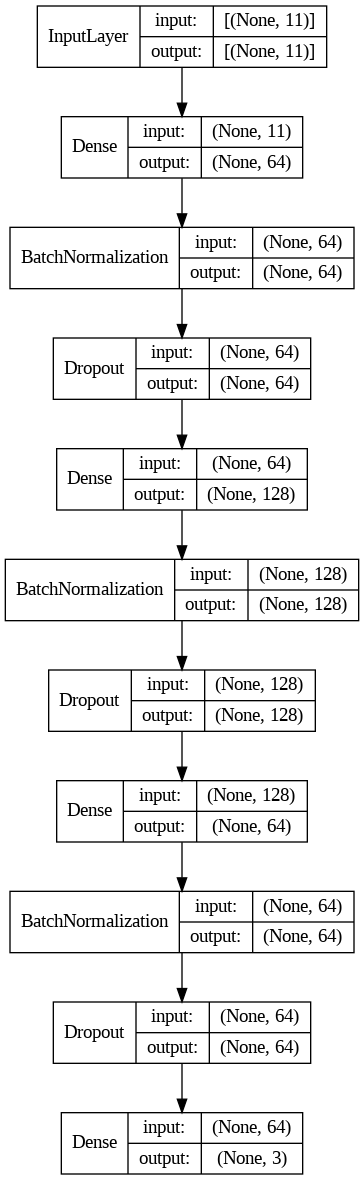

In [ ]:
from keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=False, )

In [ ]:
model.fit(
    x=X_train,
    y=y_train,
    batch_size = 16, 
    epochs=50,
    validation_data=(X_val, y_val)
)

Epoch 1/50
48/48 [==============================] - 8s 15ms/step - loss: 0.8408 - accuracy: 0.6680 - val_loss: 0.8131 - val_accuracy: 0.6507
Epoch 2/50
48/48 [==============================] - 0s 8ms/step - loss: 0.5985 - accuracy: 0.7464 - val_loss: 0.5912 - val_accuracy: 0.7636
Epoch 3/50
48/48 [==============================] - 1s 15ms/step - loss: 0.5834 - accuracy: 0.7817 - val_loss: 0.4954 - val_accuracy: 0.8074
Epoch 4/50
48/48 [==============================] - 1s 16ms/step - loss: 0.5963 - accuracy: 0.7765 - val_loss: 0.4379 - val_accuracy: 0.8287
Epoch 5/50
48/48 [==============================] - 1s 12ms/step - loss: 0.5127 - accuracy: 0.8013 - val_loss: 0.4324 - val_accuracy: 0.8127
Epoch 6/50
48/48 [==============================] - 1s 12ms/step - loss: 0.5795 - accuracy: 0.7673 - val_loss: 0.4602 - val_accuracy: 0.8048
Epoch 7/50
48/48 [==============================] - 1s 12ms/step - loss: 0.5491 - accuracy: 0.7778 - val_loss: 0.4809 - val_accuracy: 0.8127
Epoch 8/50
48/

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)

21/21 [==============================] - 0s 6ms/step - loss: 0.3787 - accuracy: 0.8491


In [ ]:
y_prob = model.predict(X_test) 
y_classes = y_prob.argmax(axis=-1)
print(y_prob)
print(y_classes)

9/9 [==============================] - 0s 2ms/step
[[9.69504416e-01 2.80876867e-02 2.40788586e-03]
 [9.17385399e-01 8.04997012e-02 2.11492600e-03]
 [9.87575769e-01 7.86775909e-03 4.55643982e-03]
 [9.71962392e-01 2.43814643e-02 3.65613517e-03]
 [8.34859908e-02 8.66363227e-01 5.01507632e-02]
 [2.94090081e-02 9.54200745e-01 1.63902249e-02]
 [1.41846053e-02 9.37031209e-01 4.87841517e-02]
 [5.26670814e-02 6.77539170e-01 2.69793689e-01]
 [7.01486319e-02 9.05600965e-01 2.42503975e-02]
 [9.88726854e-01 6.71210466e-03 4.56099818e-03]
 [9.90476489e-01 4.78995545e-03 4.73355269e-03]
 [9.88908827e-01 6.02078112e-03 5.07039763e-03]
 [5.37326276e-01 4.30573910e-01 3.20997611e-02]
 [3.65369171e-02 9.39449549e-01 2.40136199e-02]
 [4.63647693e-02 9.51916933e-01 1.71832601e-03]
 [9.14500561e-03 9.68393624e-01 2.24613082e-02]
 [1.41458381e-02 9.35934305e-01 4.99198474e-02]
 [6.75239339e-02 9.21783447e-01 1.06925787e-02]
 [7.33925521e-01 2.59537309e-01 6.53725909e-03]
 [9.84484553e-01 1.29151167e-02 2.600

# 5. Convert model

In [ ]:
# Define paths to model files
import os
MODELS_DIR = 'models/'
os.mkdir(MODELS_DIR)
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model_no_quant.tflite'

In [ ]:
import tensorflow as tf 

# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
model_no_quant_tflite = converter.convert()

# # Save the model to disk
open(MODEL_NO_QUANT_TFLITE, "wb").write(model_no_quant_tflite)
!echo "const unsigned char model[] = {" > /content/model.h
!cat /content/models/model_no_quant.tflite | xxd -i      >> /content/model.h
!echo "};"                              >> /content/model.h
